## Problem

#### COVID-19 crisis 

<div><img width="400px" height="auto" src="https://images.unsplash.com/photo-1574515944794-d6dedc7150de?ixlib=rb-1.2.1&ixid=MXwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHw%3D&auto=format&fit=crop&w=1532&q=80" /></div>

https://www.kaggle.com/kimjihoo/coronavirusdataset/

### Introduction: Who has Covid-19 in South Korea? 😷

In recent months, many people have created various studies on coronavirus. Most of them are based on various types of aggregates. The virus has already been over a year and therefore more and more interesting, detailed and accurate data appear. Although this dataset only applies to one country - South Korea.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

import scipy.stats as stats
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans 

import warnings
warnings.filterwarnings('ignore')

In [ ]:
patient =  pd.read_csv('PatientInfo.csv')
region = pd.read_csv('Region.csv')
policy=pd.read_csv('Policy.csv')
time = pd.read_csv('Time.csv')
patient.head()

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,male,50s,Korea,Seoul,Gangseo-gu,overseas inflow,NaN,75,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,male,30s,Korea,Seoul,Jungnang-gu,overseas inflow,NaN,31,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,male,50s,Korea,Seoul,Jongno-gu,contact with patient,2002000001,17,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,male,20s,Korea,Seoul,Mapo-gu,overseas inflow,NaN,9,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,female,20s,Korea,Seoul,Seongbuk-gu,contact with patient,1000000002,2,NaN,2020-01-31,2020-02-24,NaN,released


In [ ]:
patient.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5165 entries, 0 to 5164
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   patient_id          5165 non-null   int64 
 1   sex                 4043 non-null   object
 2   age                 3785 non-null   object
 3   country             5165 non-null   object
 4   province            5165 non-null   object
 5   city                5071 non-null   object
 6   infection_case      4246 non-null   object
 7   infected_by         1346 non-null   object
 8   contact_number      791 non-null    object
 9   symptom_onset_date  690 non-null    object
 10  confirmed_date      5162 non-null   object
 11  released_date       1587 non-null   object
 12  deceased_date       66 non-null     object
 13  state               5165 non-null   object
dtypes: int64(1), object(13)
memory usage: 565.0+ KB


There is quite a bit of data missing. For deceased_date, patients with missing `deceased_date` just implies that they are discharged or isolated.

In [ ]:
print(f'There are {patient.shape[0]} patients information and {patient.shape[1]} attributes in this dataset.')

There are 5165 patients information and 14 attributes in this dataset.


### **Exploratory Data Analysis**

In this secton, I invite you for a short analysis in which we'll answer such questions as:

- When was the first case of coronavirus recorded in south korea?
- Who is infected: What is the age range of infected people?
- How did these people get infected?
- How many confirmed cases did south korea have from the start of the pandemic up until June 30, 2020?
- How many deaths did south korea have from the start of the pandemic up until June 30, 2020?
- How long does the average duration of treatment take?
- What regions were the most affected by the coronavirus?
- What Policies did the government enforce to protect the people?


**When was the first case of coronavirus recorded in south korea?**

In [ ]:
patient['confirmed_date'] = patient['confirmed_date'].astype('datetime64[ns]')
patient[patient['confirmed_date']==patient['confirmed_date'].min()]

,patient_id,sex,age,country,province,city,infection_case,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
1644,1400000001,female,30s,China,Incheon,etc,overseas inflow,NaN,NaN,2020-01-19,2020-01-20,2020-02-06,NaN,released


The first person in Korea to detect a virus is a woman in her 30s (detected on January 20, 2020), as we can see the data. She became infected abroad and came to Korea already with the virus.

**Who is infected: What is the age range of infected people?**

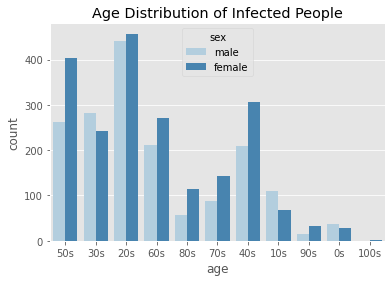

In [ ]:
sns.countplot(x='age', 
              hue='sex',
              data=patient, 
              palette='Blues').set_title('Age Distribution of Infected People')
plt.show()

The most frequently infected people are people between 20 and 30 years old and between 50 and 60 (slightly more often women than men)

**How did these people get infected?**

We're now looking at how people were infected:

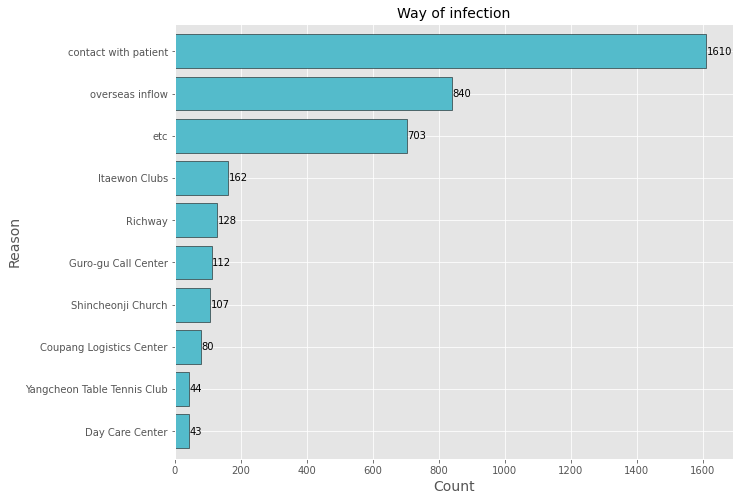

In [ ]:
ax=patient['infection_case'].value_counts()[:10].sort_values()
ax.plot.barh(width=0.8,figsize = (10,8),edgecolor = "k",color='#54BBCB')
for i,j in enumerate(ax):
    plt.text(j+1,i,j,va='center')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Reason', fontsize=14)
plt.title("Way of infection", fontsize=14)
plt.show()

The most common reason is contact with another infected person. Many people also became infected abroad and came to Korea already with the virus. It is also worth paying attention to the threats in places of religious worship - even over 100 people got infected in one church.

**Total Coronavirus Cases in South Korea**

How many confirmed cases did south korea have from the start of the pandemic up until June 30, 2020. 

To do this we will merge the dataset containing patients Information with specific columns from the time dataset  that contains the total number of confirmed cases.

In [ ]:
time['date'] = pd.to_datetime(time['date'])

patient_time=pd.merge(time[['date','confirmed','released','deceased']], 
         patient[['confirmed_date','age','sex','province']],
         left_on='date',right_on='confirmed_date',
         how='inner').drop(columns= ['confirmed_date'])

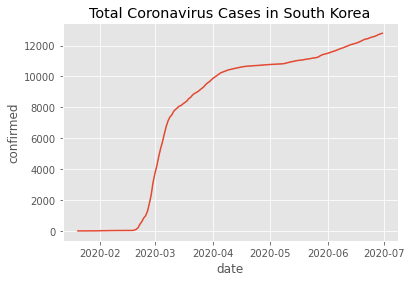

In [ ]:
sns.lineplot(x='date', y='confirmed', data=patient_time).set_title('Total Coronavirus Cases in South Korea')
plt.show()

As at June 30,2020, South-korea has reported 12,800 cases from 28 cases in the middle of february.

**Total Coronavirus Deaths in South Korea**


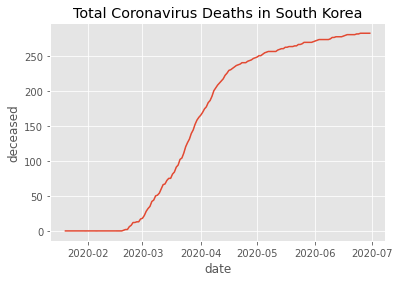

In [ ]:
sns.lineplot(x='date', y='deceased', data=patient_time).set_title('Total Coronavirus Deaths in South Korea')
plt.show()

As at June 30,2020, South-korea has reported about 282 confirmed deaths.

**How long does the average duration of treatment take?**

We're now looking at the people being treated. We check how much time they needed to recover from the time they were diagnosed with the infection (positive coronavrius test). 

In [ ]:
patient['released_date'] = patient['released_date'].astype('datetime64[ns]')

patient["days_to_recovery"] = patient["released_date"] - patient["confirmed_date"]
patient["days_to_recovery"] = patient["days_to_recovery"].dt.days

#descriptive stats
patient["days_to_recovery"].describe()

count    1587.000000
mean       24.731569
std        13.051060
min         0.000000
25%        16.000000
50%        23.000000
75%        31.000000
max       114.000000
Name: days_to_recovery, dtype: float64

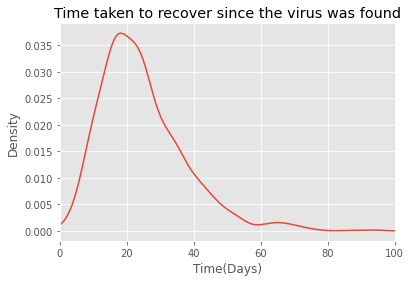

In [ ]:
patient["days_to_recovery"].plot(kind='kde',)
plt.xlim(0,100)
plt.xlabel('Time(Days)')
plt.title("Time taken to recover since the virus was found")
plt.show()

**Observations**

The time distribution for such people has a `right skewed(positive distribution)` and most people needed between 13 and 38 days(2-6 weeks).Cases over a month are very rare, however, it has often happened that only a few days after diagnosis, people could already be considered healthy.

**What regions were the most affected by the coronavirus?**

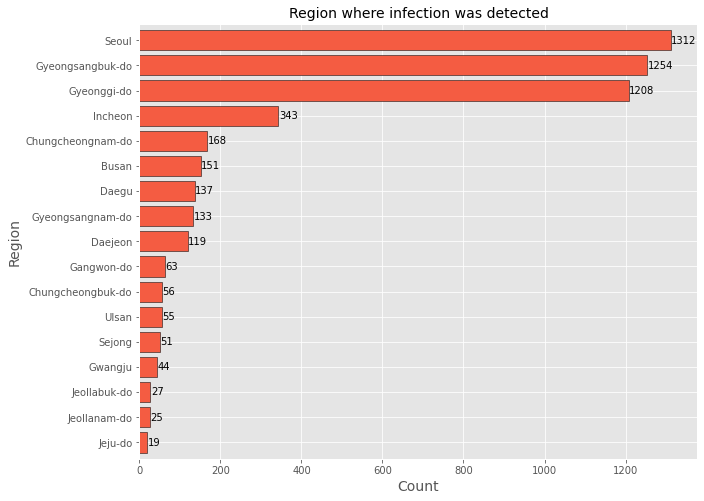

In [ ]:
ax=patient['province'].value_counts().sort_values()
ax.plot.barh(width=0.8,figsize = (10,8),edgecolor = "k",color='#f45c42')
for i,j in enumerate(ax):
    plt.text(j+1,i,j,va='center')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Region', fontsize=14)
plt.title("Region where infection was detected", fontsize=14)
plt.show()

Highest infection came from Seoul, Gyeongsangbuk-do, and Gyeonggi-do where there was the uncontrolled spread of the virus due to shincheonji (religious cult).

**What Policies did the government enforce to protect the people?**

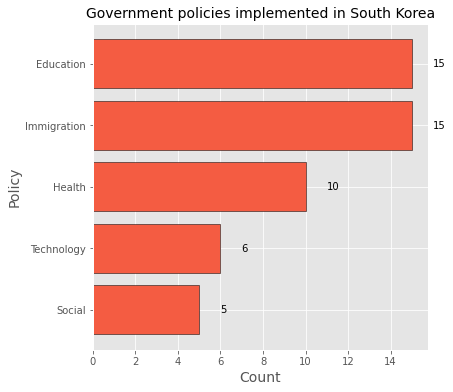

In [ ]:
ax=policy['type'].value_counts()[:5].sort_values()
ax.plot.barh(width=0.8,figsize = (6,6),edgecolor = "k",color='#f45c42')
for i,j in enumerate(ax):
    plt.text(j+1,i,j,va='center')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Policy', fontsize=14)
plt.title("Government policies implemented in South Korea", fontsize=14)
plt.show()

1. Most frequently implemented policies is for education
    - especially on the delay of school opening and its alternatives(online classes)
2. A tie policy type are on immigrations
    - because the immigration policies are specific to each country
3. 3rd are about public heath
    - the authorization for diagnostic kit, social distancing campaigns, and mask distributions

**State of confirmed cases**

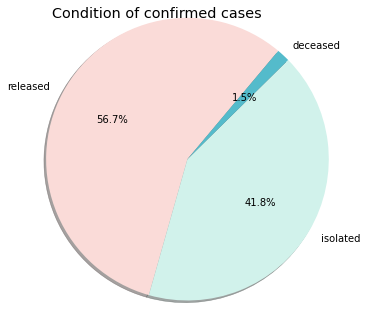

In [ ]:
plt.figure(figsize=(10,5))
                         
color = ("#FADBD8", "#D1F2EB","#54BBCB")
plt.pie(patient["state"].value_counts(), data = patient, labels=("released", "isolated", "deceased"), 
        autopct="%1.1f%%", colors=color, shadow=True, startangle=50, radius=1.3)
plt.title("Condition of confirmed cases", loc="left")
plt.show()

1.5% of the patient population is deceased. The distribution of target label (released/deceased/isolated) is unbalanced.

**Observation on dataset:**

1. The informations on 40% patients are logged in patient data (5165 among 12800 confirmed patients)
2. Which means 60% patients are confirmed but under-documented

### 🧪**Statistical tests**
Is there a significant difference in the ratio between the number of people who test positive and the number of people who died(for both genders)?




**Hypothesis 1**

$H_0 :$ There is no difference between males/female death ratio

$H_a :$ There is a difference between males/female death ratio


Now we are going to check if there is a significant difference in the number of patients who have died for both males and females

Using the `patient_time` dataset from earlier. Since we have a cumulative sum of the confirmed cases, we will use the `.diff()` here, and then fill the NaN of the first record with the corresponding value in the CumSum column


In [ ]:
patient_time['daily_count_confirmed']=  patient_time['confirmed'].diff().fillna(patient_time['confirmed'])
patient_time['deceased']=  patient_time['deceased'].diff().fillna(patient_time['confirmed'])
patient_time["death_ratio"] = patient_time['deceased']/patient_time['confirmed']

In [ ]:
grouped = patient_time.groupby('sex').sum()
grouped[['daily_count_confirmed','deceased']]

,daily_count_confirmed,deceased
sex,,
female,4803.0,81.0
male,5631.0,115.0


In [ ]:
confirmed_females = grouped['daily_count_confirmed'][0]
confirmed_males = grouped['daily_count_confirmed'][1]

deceased_females = grouped['deceased'][0]
deceased_males = grouped['deceased'][1]

For a 95% confidence level:

In [ ]:
#t-test
patient_time["death_ratio"] = patient_time['deceased']/patient_time['confirmed']
ttest_ind(patient_time[patient_time['sex'] == 'male']['death_ratio'], 
          patient_time[patient_time['sex'] == 'female']['death_ratio'])

Ttest_indResult(statistic=-0.8752353901011848, pvalue=0.38149789684472957)

The p-value here is 0.3, which is not below our alpha of 0.05. Therefore we fail to reject the null hypothesis.There is no significant difference between the death in both genders.

Another alternative approach using normalstats' proportion z-test function would have looked like this:

In [ ]:
#calculate the number of observations for each group and store results in an array
n_confirmed = np.array([confirmed_males, confirmed_females])
#calculate the number of deceased for each group and store results in an array
n_deceased = np.array([deceased_males, deceased_females])

#calculate the test-statistic Z and corresponding p_value
z_statistic, p_value = proportions_ztest(n_deceased, n_confirmed, value=0, alternative="two-sided")

print(f"z-test-statistic: {z_statistic}")
print(f"p-value: {p_value}")

if (p_value<0.05):
    print('Hypothesis_Status = Reject Null Hypothesis : Significant')
else:
    print('Hypothesis_Status = Do not reject Null Hypothesis : Not Significant')

z-test-statistic: 1.3343485827562758
p-value: 0.182089642540316
Hypothesis_Status = Do not reject Null Hypothesis : Not Significant


The p-value here is 0.18, which is not below our alpha of 0.05. Therefore we fail to reject the null hypothesis.There is no significant difference between deaths out of confirmed cases in both genders

The z-test and t-test did not differ too much in this experiment. Now Why?

Because for a sample size greater than 30, the t-statistic gives similar results as a z-statistics would for larger samples.

**Stratifying Split Data**

First, some pre-processing, one-hot encoding the categorical variables


In [ ]:
patient=patient[patient['country'] == 'Korea']

patient['age'].dropna(axis=0,inplace=True)
patient['age']=patient['age'].str.replace('s','')
patient['contact_number']=patient['contact_number'].replace('-',0)
patient['age'].astype('float64')
patient.fillna(0,inplace = True)
patient.dropna(inplace=True)

In [ ]:
patient=patient.drop(['patient_id','symptom_onset_date','confirmed_date','released_date'], axis=1)

patient_encoded = pd.get_dummies(data=patient, columns=["sex","country", "province", "city","infection_case","deceased_date"], drop_first=True)


In [ ]:
#Remove active cases
active_cases = patient[patient['state'] == 'isolated'].index
patient=patient.drop(active_cases)
patient_encoded=patient_encoded.drop(active_cases)

In [ ]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
patient_encoded['state'] = labelencoder.fit_transform(patient_encoded['state'])

**🪓 Split the data**

In [ ]:
X=patient_encoded.drop('state', axis=1)
y=patient_encoded['state']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, 
                                                    random_state=0, stratify=y)

#### ⚖️ Feature scaling
Feature scaling through standardization (or Z-score normalization) can be an important preprocessing step for many machine learning algorithms. PCA is effected by scale so we need to scale the features in the data before applying PCA.

We will use StandardScaler to help standardize the dataset’s features onto unit scale (mean = 0 and SD = 1)
Encoded categorical variables contain values on 0 and 1. Therefore, there is even no need to scale them. We will only be scaling data that was orignally numeric

In [ ]:
from sklearn.preprocessing import StandardScaler
original_numeric_data =  patient_encoded[['age','infected_by', 'contact_number','days_to_recovery']]
X[['age','infected_by', 'contact_number','days_to_recovery']] = StandardScaler().fit_transform(original_numeric_data)

❗PCA VS TSNE

**Curse of Dimensionality & Dimensionality Reduction**

The term "Curse of Dimensionality" has often been thrown about, especially when PCA and TSNE is thrown into the mix. This phrase refers to how our perfectly good and reliable Machine Learning methods may suddenly perform badly when we are dealing in a very high-dimensional space. But what exactly do all these 2 acronyms do? They are essentially transformation methods used for dimensionality reduction. Therefore, if we are able to project our data from a higher-dimensional space to a lower one while keeping most of the relevant information, that would make life a lot easier for our learning methods.

In this section we will perform dimensionality reduction on encoded patient information, then verify data separability by the patient's state(PCA and t-SNE)

In [ ]:
import plotly.express as px
pca = PCA()
principal_components = pca.fit_transform(X)

exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"})
fig.show()

From the plot, We can also look at the proportion of variance explained to determine how many features are required to explain, say, about 95% of the variance (cutoffs are somewhat arbitrary here, and usually decided upon by ‘rules of thumb’).

For 95%, the plot shows number of components=56. We will use this

In [ ]:
pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(X)

Let us examine the variance explained by each principal component.This will provide us with the amount of information or variance each principal component holds after projecting the data to a lower dimensional subspace.

In [ ]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_[:6])

Proportion of Variance Explained :  [0.22554047 0.16139824 0.14446335 0.11022378 0.06273238 0.04035191]


We can clearly see that the first six principal components explains over 70% of the variation in the data.

Now we can use the top two principal components and make scatter plot. We will use Seaborn’s relplot to make the PCA plot.

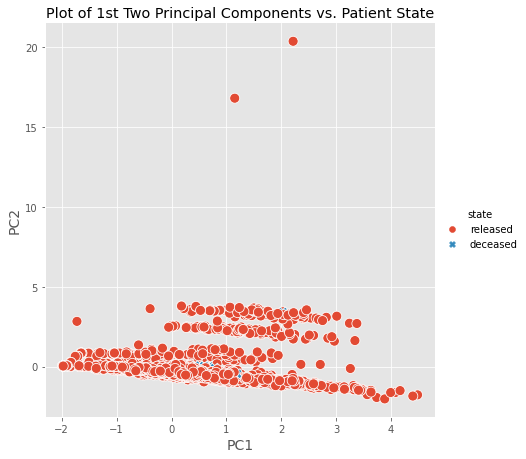

In [ ]:
ax=sns.relplot(x=principal_components[:, 0], y=principal_components[:, 1], hue=patient.state, style=patient.state, height=6, s=100)
ax.set_axis_labels("PC1", "PC2", fontsize = 14)
ax.set(title="Plot of 1st Two Principal Components vs. Patient State")
plt.show()

It is obvious that the patient's state did not neatly seperate

**TSNE**

In [ ]:
tsne = TSNE(n_components=2, perplexity=30, random_state=10)
X_tsne = tsne.fit_transform(X)

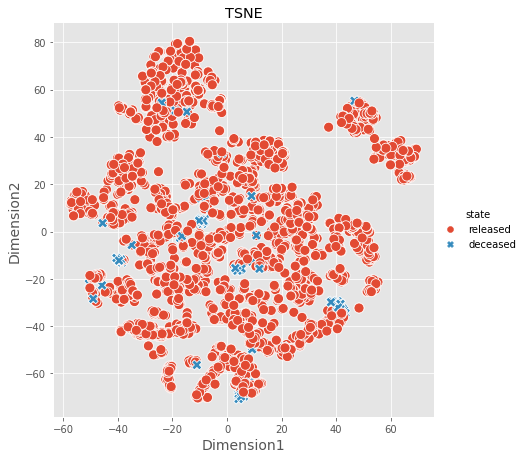

In [ ]:
ax=sns.relplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=patient.state, style=patient.state, height=6, s=100)
ax.set_axis_labels("Dimension1", "Dimension2", fontsize = 14)
ax.set(title="TSNE")
plt.show()

T-SNE can often times show clear separation in the data. t-SNE however is not a clustering approach since it does not preserve the inputs like PCA and the values may often change between runs so it’s purely for exploration in this case.

**🚊 Train a logistic regression model to classify the patient's state:**

In [ ]:
logreg = LogisticRegression(random_state=42, class_weight='balanced')
logreg.fit(X_train, y_train)

#Predicting the test set results and calculating the accuracy
predictions = logreg.predict(X_test)
print(f'Accuracy of logistic regression classifier on test set: {round(logreg.score(X_test, y_test),2)}')

Accuracy of logistic regression classifier on test set: 0.42


In [ ]:
predictions_inverse=labelencoder.inverse_transform(predictions)
classified_df = pd.DataFrame({'predictions': predictions_inverse, 'actual_state_of_patient':labelencoder.inverse_transform(y_test)})
classified_df[classified_df['predictions'] != classified_df['actual_state_of_patient']]

,predictions,actual_state_of_patient
0,deceased,released
1,deceased,released
2,deceased,released
4,deceased,released
5,deceased,released
...,...,...
884,deceased,released
888,deceased,released
889,deceased,released
890,deceased,released


✨**K-Means Clustering: Cluster patient's state**

Imagine just for a moment that we were not provided with the patient's state to this patient Information dataset because after all PCA is an unsupervised method. How would we be able to separate out our data points in the new feature space? We can apply a clustering algorithm on our PCA projection data and hopefully arrive at distinct clusters which would tell us something about the underlying class separation in the data.

To start off, we set up a KMeans clustering method with Sklearn's KMeans call and use the fit_predict method to compute cluster centers and predict cluster indices for the first and second PCA projections (to see if we can observe any appreciable clusters).

In [ ]:
sse = []
for k in range(1, 11): 
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(principal_components)
    sse.append(kmeans.inertia_)

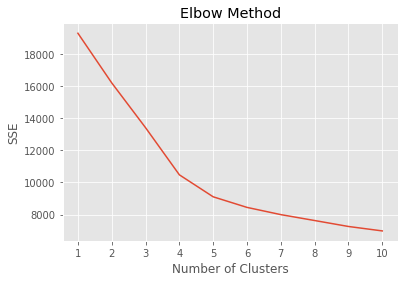

In [ ]:
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title('Elbow Method')
plt.show()

Determining the elbow point in the SSE curve isn’t always straightforward. For this, we could use a Python package, kneed, to identify the elbow point programmatically like this:

In [ ]:
from kneed import KneeLocator

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing" )
print(f'Yoda says you should make {kl.elbow} clusters. Listen to Yoda')

Yoda says you should make 5 clusters. Listen to Yoda


In [ ]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(principal_components)
X_clustered=kmeans.predict(principal_components)

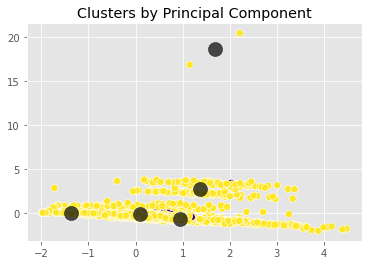

In [ ]:
ax=sns.scatterplot(principal_components[:, 0],principal_components[:, 1], c=patient_encoded.state, s=50, cmap='viridis')
ax.set(title="Clusters by Principal Component")

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.7)
plt.show()

In [ ]:
df_pca_kmeans = pd.concat([patient.reset_index(drop=True), pd.DataFrame(principal_components).iloc[:,0:2]],axis=1, sort=False)
df_pca_kmeans.columns.values[-2:] = ['PC1', 'PC2']
df_pca_kmeans['segment'] = kmeans.labels_
df_pca_kmeans[df_pca_kmeans.segment==1].head(10)

,sex,age,country,province,city,infection_case,infected_by,contact_number,deceased_date,state,days_to_recovery,PC1,PC2,segment
1,male,30,Korea,Seoul,Jungnang-gu,overseas inflow,0,31,0,released,32.0,0.150970,-0.523012,1
28,male,50,Korea,Seoul,Songpa-gu,etc,0,0,0,released,26.0,0.557000,-0.515025,1
32,male,30,Korea,Seoul,etc,etc,0,0,0,released,24.0,-0.048933,-0.437015,1
67,female,30,Korea,Seoul,Nowon-gu,etc,0,0,0,released,21.0,-0.072360,-0.392591,1
1117,female,40,Korea,Gwangju,0,overseas inflow,0,450,0,released,17.0,0.181076,-0.349167,1
1119,male,30,Korea,Gwangju,0,etc,0,65,0,released,28.0,0.393245,-0.523566,1
1120,male,30,Korea,Gwangju,0,contact with patient,1300000003,30,0,released,26.0,0.572639,0.528016,1
1121,male,30,Korea,Gwangju,0,etc,0,156,0,released,24.0,0.232283,-0.463328,1
1122,male,30,Korea,Gwangju,0,contact with patient,1300000003,14,0,released,24.0,0.492158,0.558134,1
1123,male,30,Korea,Gwangju,0,contact with patient,1300000003,39,0,released,24.0,0.492158,0.558134,1


**Conclusions:**

So far we have seen:
- South Korea's first case was a woman in her 30s (detected on January 20, 2020). South Korea was one of the first countries to experience a COVID-19 outbreak, she got it abroad and travelled to korea with it.

- They are most often found in the capital of South Korea, Seoul. Not surprising, it is a huge metropolis where modern skyscrapers, high-tech subways and pop culture meet Buddhist temples, palaces and street markets.

- The most frequently infected people are people between 20 and 30 years old and between 50 and 60 (slightly more often women than men), but as we have seen from the statistical test that there is no significant difference in the people who die out of this confirmed cases in both genders

